Testing reliability of anatomical signals in relation to number of acquisitions

In [10]:
import nibabel as nib
import os
from brainsss2.imgmath import imgmath
import ants
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from brainsss2.columnwise_corrcoef_perf import AlmightyCorrcoefEinsumOptimized

In [15]:
basedir = '/data/brainsss/processed/fly_001/anat_0/imaging/'

origfile = os.path.join(basedir, 'anatomy_channel_1.nii')
meanfile = os.path.join(basedir, 'anatomy_channel_1_mean.nii')
if not os.path.exists(meanfile):
    meanfile = imgmath(origfile, 'mean')

meanimg = nib.load(meanfile)

# get mask to select voxels
maskfile = meanfile.replace('_mean.nii', '_mask.nii')
if not os.path.exists(maskfile):
    meanimg_ants = ants.image_read(meanfile)
    mask_ants = ants.get_mask(meanimg_ants,
        low_thresh=None,
        cleanup=4)
    mask_img = mask_ants.to_nibabel()
    mask_img.header.set_data_dtype('uint8')
    mask_img.header.set_zooms(meanimg.header.get_zooms())
    mask_img.header.set_qform(meanimg.header.get_qform())
    mask_img.header.set_sform(meanimg.header.get_sform())
    mask_img.header.set_xyzt_units('mm', 'sec')
    mask_img.to_filename(maskfile)
else:
    mask_img = nib.load(maskfile)



computing mean of nii file
saving mean of /data/brainsss/processed/fly_001/anat_0/imaging/anatomy_channel_1.nii to file /data/brainsss/processed/fly_001/anat_0/imaging/anatomy_channel_1_mean.nii


In [16]:
# compute reliability of random samples of varying size

origimg = nib.load(origfile)

def get_flattened_data(img, mask, start, length, out_resolution=None):
    data = img.dataobj[:, :, :,start:(start + length)]
    meandata = data.mean(axis=-1)
    if out_resolution is not None:
        res = [out_resolution] * 3
        meanimg = nib.Nifti1Image(meandata, mask.affine)
        meanimg.header.set_zooms(img.header.get_zooms()[:3])
        meanimg.header.set_qform(img.header.get_qform())
        meanimg.header.set_sform(img.header.get_sform())
        meanimg.header.set_xyzt_units('mm', 'sec')
        meanimg_resamp = nib.processing.resample_to_output(meanimg, res)
        meandata = meanimg_resamp.get_fdata()
        maskimg_resamp = nib.processing.resample_to_output(mask, res)
        maskdata = (maskimg_resamp.get_fdata() > 1e-6).astype(int)
    else:
        maskdata = mask_img.get_fdata().astype("int")
    return(meandata[maskdata==1])

cc = {}

for out_resolution in [None, 2]:
    print(f'out_resolution: {out_resolution}')
    # get two sets of data
    starts = [0, int(origimg.shape[-1]/2)]
    cc[out_resolution] = {}
    for length in range(2,51, 2):
        data_vec = {}
        for i, start in enumerate(starts):
            data_vec[i] = get_flattened_data(
                origimg, mask_img, start, length,
                out_resolution=out_resolution)
        cc[out_resolution][length] = AlmightyCorrcoefEinsumOptimized(
            data_vec[0][:, np.newaxis], data_vec[1][:, np.newaxis])[0][0]
        # print(f'{length} {cc[length]}')

out_resolution: None
out_resolution: 2


In [17]:

cc_df = pd.DataFrame(cc[None].items(), columns=['length', 'cc'])
cc_df['out_resolution'] = 'orig'

df_2 = pd.DataFrame(cc[2].items(), columns=['length', 'cc'])
df_2['out_resolution'] = '2mm iso'

full_df = pd.concat((cc_df,  df_2))
full_df.head()
full_df = full_df.reset_index()

Text(0, 0.5, 'correlation coefficient')

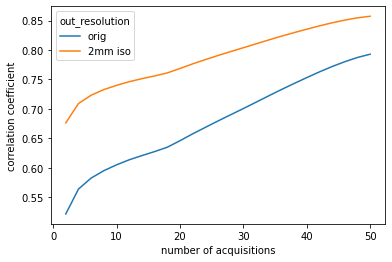

In [18]:
sns.lineplot(x='length', y='cc', hue='out_resolution', data=full_df)
plt.xlabel('number of acquisitions')
plt.ylabel('correlation coefficient')